# NYC Bustime Data Analysis

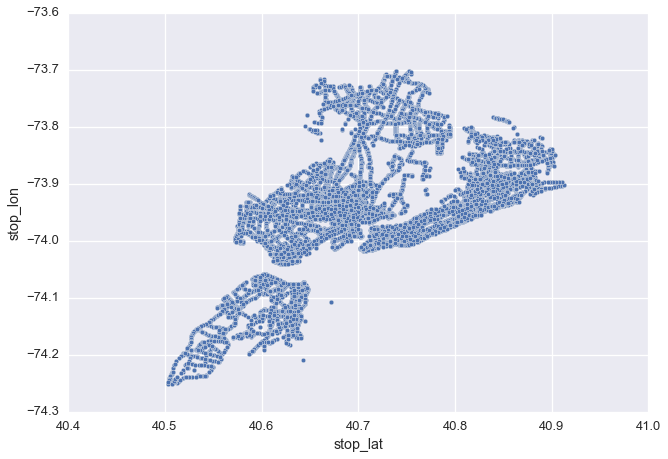

In [36]:
stops.plot(kind='scatter', x='stop_lat', y='stop_lon')

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

pd.set_option('notebook_repr_html', True)
pd.set_option('display.mpl_style', 'default') 

import seaborn as sns
sns.set_context("talk")
sns.set_style("darkgrid")
pd.set_option('precision', 10)
print('done!')


done!


# Import Datasets

In [10]:
shapes = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/shapes.txt.gz", compression='gzip')
agency = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/agency.txt.gz", compression='gzip')
trips = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/trips.txt.gz", compression='gzip')
routes = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/routes.txt.gz", compression='gzip')
stop_times = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/stop_times.txt.gz", compression='gzip')
calendar_dates = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/calendar_dates.txt.gz", compression='gzip')
stops = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/stops.txt.gz", index_col='stop_id', compression='gzip')
calendar = pd.read_csv("https://s3-us-west-2.amazonaws.com/data-incubator/calendar.txt.gz", index_col='service_id', compression='gzip')

# Realtime traffic data
real_time_data = "https://s3-us-west-2.amazonaws.com/data-incubator/realtime.csv.gz"
realtime = pd.read_csv(real_time_data, compression='gzip', index_col=0, parse_dates=True)
print("{:,} rows x {} cols".format(realtime.shape[0], realtime.shape[1]))

2,846,294 rows x 12 cols


# Data Preparation

In [3]:
# Add relevant columns from `trips` to `realtime`
full_rt_trips = pd.merge(realtime[['timestamp', 'vehicle_id', 'progress', 'trip_id', 'dist_along_route', 'next_stop_id']],
                         trips[['route_id', 'direction_id', 'trip_id']], 
                         left_on='trip_id', right_on='trip_id', how='inner')
print(full_rt_trips.shape)

# Add relevant columns from `routes` to merged `realtime + trips`
rt_full_trips_routes = pd.merge(full_rt_trips, routes[['route_id', 'route_desc']], 
                                left_on='route_id', right_on='route_id', how='inner')
print(rt_full_trips_routes.shape)
rt_full_trips_routes.head(3)


(2334161, 8)
(2334161, 9)


,timestamp,vehicle_id,progress,trip_id,dist_along_route,next_stop_id,route_id,direction_id,route_desc
0,2015-01-27 23:46:45,4817,2,EN_A5-Weekday-SDon-001000_B42_1,2205.68,940151,B42,0,via Rockaway Pkwy
1,2015-01-27 23:47:16,4817,2,EN_A5-Weekday-SDon-001000_B42_1,2205.68,940151,B42,0,via Rockaway Pkwy
2,2015-01-27 23:47:48,4817,2,EN_A5-Weekday-SDon-001000_B42_1,2205.68,940151,B42,0,via Rockaway Pkwy
3,2015-01-27 23:48:52,4817,2,EN_A5-Weekday-SDon-001000_B42_1,2205.68,940151,B42,0,via Rockaway Pkwy
4,2015-01-27 23:49:54,4817,2,EN_A5-Weekday-SDon-001000_B42_1,2205.68,940151,B42,0,via Rockaway Pkwy


## 2a.) What is the median number of trips made by a single vehicle?

In [ ]:
# Count Number of trips made by each vehicle
tot_trips_per_veh = rt_full_trips_routes[['vehicle_id', 'trip_id']].groupby('vehicle_id').count()

med = tot_trips_per_veh.median().values
print("\n\n Median : {:.7f} ".format(med[0]))



 Median : 635.5000000 


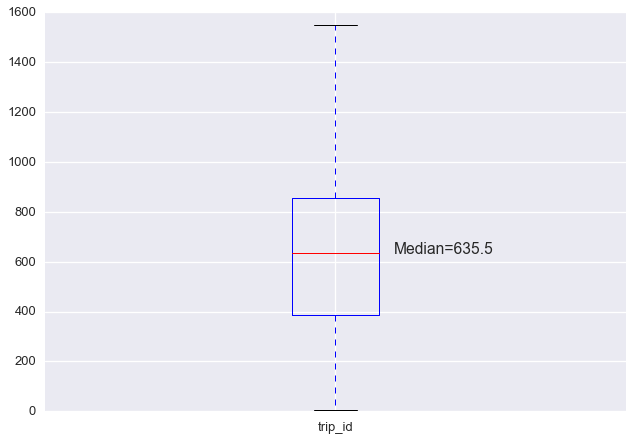

In [4]:
ax = tot_trips_per_veh.plot(kind='box')
ax.annotate('Median='+str(med[0]), xy=(1.1,med[0]))

## 2b.) Highest total number of trips made by a Mahattan Bus route

In [ ]:
# Get all trips made by each Mahattan bus
rt_mahattan_bus_routes = full_rt_trips[full_rt_trips.route_id.str.startswith('M')] 
mhtn_bus_trips = rt_mahattan_bus_routes[['trip_id','route_id']].groupby('route_id').count()

# Sort and get highest total trips
mhtn_bus_trips.sort_values('trip_id', ascending=False, inplace=True)
max_trip = mhtn_bus_trips.trip_id.max()
print("\nHighest total trip: {:.5f} ".format(max_trip))
print('\n\n',mhtn_bus_trips.head())


Highest total trip: 28816.00000 


           trip_id
route_id         
M101        28816
M15         24274
M15+        23767
M4          23334
M5          20828


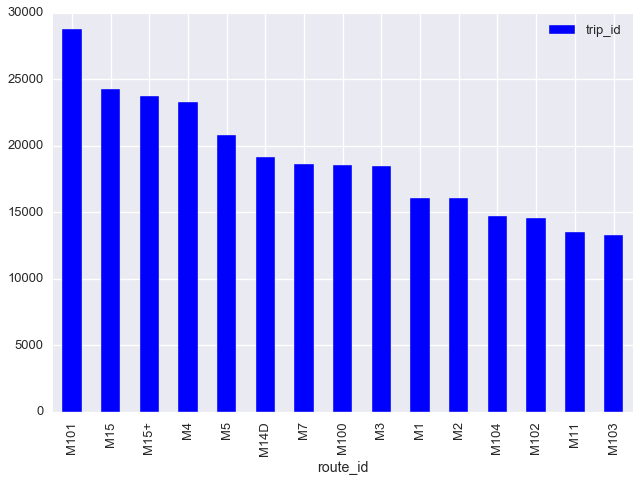

In [5]:
# Plot
mhtn_bus_trips.head(10).plot(kind='bar')

## 2c) Second Highest Average Speed

In [31]:
# Mahattan bus routes
rt_mahattan_bus_routes = full_rt_trips[full_rt_trips.route_id.str.startswith('M')] 

# Merge stop times information
df = pd.merge(stop_times[['trip_id', 'departure_time', 'stop_id', 'stop_sequence']], 
              rt_mahattan_bus_routes, left_on='trip_id', right_on='trip_id')

sel_cols = ['route_id', 'dist_along_route', 'departure_time', 'timestamp']
rt_mhtn_bus_route_times = df[sel_cols].copy()

print(rt_mhtn_bus_route_times.shape)



def change_bad_date(xtime):
    try:
        new_time = pd.to_datetime(xtime)
    except ValueError:
        hr, ms, sec = xtime.split(':')
        new_hr = divmod(int(hr), 24)
        new_time = (':').join([str(new_hr)[1], ms, sec])
        new_time = pd.to_datetime(new_time)
    return new_time


# Test
change_bad_date(xtime = "23:42:12")



# Find time interval
def findinterval(dfm):
    if dfm['new_timestamp'] < dfm['mod_depart_time']:
        dfm['new_timestamp'] += pd.Timedelta(days=1)
    return dfm['new_timestamp'] - dfm['mod_depart_time']

rt_mhtn_bus_route_times.tail()

(19367240, 4)


,route_id,dist_along_route,departure_time,timestamp
19367235,M103,11491.41,24:36:00,2015-01-29 00:48:52
19367236,M103,12274.6,24:36:00,2015-01-29 00:49:54
19367237,M103,12274.6,24:36:00,2015-01-29 00:50:26
19367238,M103,12274.6,24:36:00,2015-01-29 00:51:28
19367239,M103,\N,24:36:00,2015-01-29 00:51:58


In [32]:
# Remove invalid route distance entries
ds = pd.Series(rt_mhtn_bus_route_times.dist_along_route)
rt_mhtn_bus_route_times.loc[:,'dist_along_route'] = pd.to_numeric(ds, errors='coerce')
rt_mhtn_bus_route_times.dropna(inplace=True)

ds = pd.Series(rt_mhtn_bus_route_times.dist_along_route)
rt_mhtn_bus_route_times.loc[:,'dist_along_route'] = ds.apply(lambda x: x * 0.00062137)
grouped = rt_mhtn_bus_route_times.groupby('route_id')

### Compute group (route) distance, time and speed

In [34]:
result_data = []

for name, grp in grouped:
    # Modify badly structured date
    group = grp.copy()
    group['mod_depart_time'] = group.departure_time.apply(change_bad_date)
    td = pd.datetime.today()    
    date = pd.to_datetime(group.timestamp)
    group['new_timestamp'] = date.apply(lambda x: x.replace(year=td.year, month=td.month, day=td.day ))
    
    # Find time interval
    group['Interval'] = group.apply(findinterval, axis=1)
    distance_mi = group.dist_along_route.unique().sum()
    time_hr = group.Interval.apply(lambda x: x / np.timedelta64(1,'h')).sum()
    avg_speed = distance_mi / time_hr
    result_data.append([name, distance_mi, time_hr, avg_speed])
    
group.head()

,route_id,dist_along_route,departure_time,timestamp,mod_depart_time,new_timestamp,Interval
4556244,M98,0.0000000000,05:50:00,2015-01-28 05:49:58,2016-02-01 05:50:00,2016-02-01 05:49:58,23:59:58
4556245,M98,0.1878712195,05:50:00,2015-01-28 05:51:01,2016-02-01 05:50:00,2016-02-01 05:51:01,00:01:01
4556246,M98,0.3373044908,05:50:00,2015-01-28 05:51:33,2016-02-01 05:50:00,2016-02-01 05:51:33,00:01:33
4556247,M98,0.4572848241,05:50:00,2015-01-28 05:52:04,2016-02-01 05:50:00,2016-02-01 05:52:04,00:02:04
4556248,M98,0.4572848241,05:50:00,2015-01-28 05:52:36,2016-02-01 05:50:00,2016-02-01 05:52:36,00:02:36


### Get Dataframe and show results

                 dist_mi            time_hr     avg_speed
route_id                                                 
M98       131.6213398554  411179.9772222206  0.0003201064
M35        29.2083481269  163764.1988888884  0.0001783561
M12        77.8501672778  596541.9502777815  0.0001305024


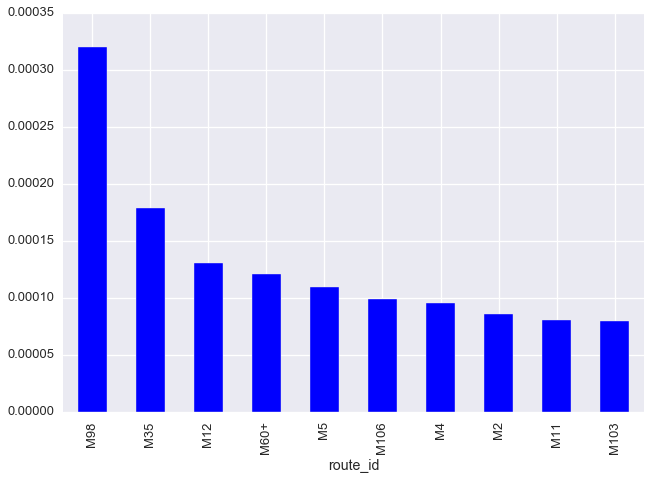

In [35]:
# Compute Speed Data
speed_data = pd.DataFrame(result_data)
speed_data.columns = ['route_id', 'dist_mi', 'time_hr', 'avg_speed']
speed_data.set_index('route_id', inplace=True)
speed_data.sort_values('avg_speed', ascending=False, inplace=True)
print(speed_data.head(3))
speed_data.head(10).avg_speed.plot(kind='bar')

## 2d) Variability of departure times

In [40]:
speed_data['minute_sqrd'] = avg_speed * 3600

print("VARIANCE : {:.9f}".format(speed_data.minute_sqrd.var()))
speed_data.head()

VARIANCE : 0.000000000
0.0


,dist_mi,time_hr,avg_speed,minute_sqrd
route_id,,,,
M98,131.6213398554,411179.9772222206,0.0003201064,1.1523830189
M35,29.2083481269,163764.1988888884,0.0001783561,1.1523830189
M12,77.8501672778,596541.9502777815,0.0001305024,1.1523830189
M60+,256.6096916622,2121686.0972222183,0.0001209461,1.1523830189
M5,1708.0108577510,15653278.4199990463,0.0001091152,1.1523830189
